In [1]:
from collections import defaultdict

# importing first because https://github.com/tensorflow/tensorflow/issues/2903
import tensorflow as tf
from tensorflow.contrib import learn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets


import features_database

%matplotlib inline

In [118]:
sa_threshold = 0.25
distance_threshold = 8

dssp_to_3 = defaultdict(
    lambda : 'C', 
    H='H',
    G='H',
    I='H',
    E='E'
)

ss_encoder = {
    'H': [1, 0, 0],
    'E': [0, 1, 0],
    'C': [0, 0, 1],   
}

window_size = 9
buffer = window_size // 2
feature_vector_size = 25
seq_len = 30

In [84]:
db = features_database.SpatialFeaturesDatabase('spatial_features.db')
structure_id = 'd16vpa_'
structure = db.retrieve(structure_id)

In [85]:
def feature_vector(structure, residue):
    features = np.ndarray(shape=(feature_vector_size))
    features[0:20] = structure['pssm'][residue]
    features[20:23] = ss_encoder[dssp_to_3[structure['secondary_structure'][residue]]]
    features[23:25] = [1, 0] if structure['solvent_accessibility'][residue] > sa_threshold else [0, 1]
    return features

def feature_vectors(structure, i, j, window_size):
    features_i = np.empty(shape=(0,))
    features_j = np.empty(shape=(0,))
    
    for index in range (i - window_size // 2, i + window_size // 2 + 1):
        features_i = np.concatenate([features_i, feature_vector(structure, index)])
    
    for index in range (j - window_size // 2, j + window_size // 2 + 1):
         features_j = np.concatenate([features_j, feature_vector(structure, index)])
                           
    cmap = structure['distance_map'][i][j] < distance_threshold
    return features_i, features_j, int(cmap)



In [86]:
features_i, features_j, cmap = feature_vectors(structure, 2, 7, window_size)
print(features_i, features_i.shape, cmap)
print('Feature vector size should be', len(features_i))

features_i, features_j, cmap = feature_vectors(structure, 2, 2, window_size)
print('Contact between residue and itself should be', cmap)

[-2. -3. -3. -4. -2. -3. -3. -3. -1.  0.  0. -3.  0.  6. -4. -2. -2.  1.
  3. -1.  0.  1.  0.  1.  0. -1. -2. -3. -4. -1. -2. -3. -4. -3.  2.  4.
 -2.  2.  0. -3. -2. -1. -2. -1.  1.  0.  0.  1.  1.  0.  1. -1.  1.  0.
 -1.  0.  0.  0. -1. -2. -2.  0. -2. -2. -1.  4.  1. -3. -2. -2.  0.  0.
  1.  1.  0. -1.  6.  0. -2. -3.  1.  0. -2.  0. -3. -2.  2. -1. -3. -2.
 -1. -1. -3. -2. -3.  0.  0.  1.  1.  0. -1. -1. -2. -3. -1.  0. -2. -3.
 -2.  1.  2. -1.  5.  0. -3. -2. -1. -1. -1.  1.  0.  0.  1.  1.  0. -1.
 -2. -2. -2. -3. -1. -1. -2. -2. -3. -3. -1. -3. -4.  7. -1. -1. -4. -3.
 -2.  0.  0.  1.  0.  1.  1. -1.  1.  0. -1.  0.  0.  0. -1. -2. -2.  0.
 -2. -2. -1.  4.  1. -3. -2. -2.  0.  0.  1.  1.  0. -1. -2. -2. -2. -3.
 -1. -1. -2. -2. -3. -3. -1. -3. -4.  7. -1. -1. -4. -3. -2.  0.  0.  1.
  1.  0. -1. -2. -2. -2. -3. -1. -1. -2. -2. -3. -3. -1. -3. -4.  7. -1.
 -1. -4. -3. -2.  0.  0.  1.  0.  1.] (225,) 0
Feature vector size should be 225
Contact between residue and itself should b

In [87]:
len(structure['distance_map']) ** 2
(structure['distance_map'] < distance_threshold).astype(int)[:seq_len, :seq_len].sum()

228

In [103]:
def get_next_training_sample(balance=True):
    negatives = 0
    contacts = structure['distance_map'] < distance_threshold
    max_negatives = contacts.astype(int)[:seq_len, :seq_len].sum()
    sequence_len = min(seq_len, len(structure['sequence']))
    for i, j in itertools.product(range(buffer, sequence_len - buffer), range(buffer, sequence_len - buffer)):
        features_i, features_j, cmap = feature_vectors(structure, i, j, window_size)
        if not balance:
            yield np.concatenate([features_i, features_j]), cmap
        else:
            if cmap == 0 and negatives < max_negatives:
                yield np.concatenate([features_i, features_j]), cmap
                negatives += 1
            elif cmap == 1:
                yield np.concatenate([features_i, features_j]), cmap
    

In [104]:
import itertools

number_of_residues = 2

astral = sklearn.datasets.base.Bunch()
astral.data = np.empty(shape=(0, window_size * feature_vector_size * number_of_residues))
astral.target = np.empty(shape=(0, 1), dtype=np.int32)

for features, cmap in get_next_training_sample():
    astral.data = np.vstack([astral.data, features])
    astral.target = np.vstack([astral.target, cmap])

In [105]:
astral.target.shape

(400, 1)

In [91]:
from sklearn import datasets, metrics
    
classifier = learn.DNNClassifier(hidden_units=[128], n_classes=2)
classifier.fit(astral.data, astral.target, steps=200)


/home/tars/.virtualenvs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1197: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)


DNNClassifier()

In [92]:
def get_next_test_sample():
    sequence_len = min(seq_len, len(structure['sequence']))
    buffer = window_size // 2

    for i, j in itertools.product(range(buffer, sequence_len - buffer), range(buffer, sequence_len - buffer)):
        features_i, features_j, cmap = feature_vectors(structure, i, j, window_size)
        yield np.concatenate([features_i, features_j]), cmap
            
astral_test = sklearn.datasets.base.Bunch()
astral_test.data = np.empty(shape=(0, window_size * feature_vector_size * number_of_residues))
astral_test.target = np.empty(shape=(0, 1), dtype=np.int32)

for features, cmap in get_next_test_sample():
    astral_test.data = np.vstack([astral_test.data, features])
    astral_test.target = np.vstack([astral_test.target, cmap])

In [93]:
training_predicted = classifier.predict(astral.data)
score = sklearn.metrics.accuracy_score(astral.target, training_predicted)
print("Training set accuracy: %f" % score)

Training set accuracy: 1.000000


In [94]:
test_predicted = classifier.predict(astral_test.data)
score = sklearn.metrics.accuracy_score(astral_test.target, test_predicted)
print("Test set accuracy: %f" % score)

Test set accuracy: 0.832645


In [110]:
astral_test.target.shape

(484, 1)

In [95]:
from pconpy import pconpy
astral_filepath = "astral/pdbstyle-2.06/" 
dataset = pd.read_csv('astral/dataset.xls', sep='\s+')
structures = dataset['DOMAIN'].tolist()

filename = astral_filepath + structure_id[2:4]  + "/" + structure_id + ".ent"
residues = pconpy.get_residues(filename)
distance_map = pconpy.calc_dist_matrix(residues).filled(0)

In [96]:
distance_map.shape

(311, 311)

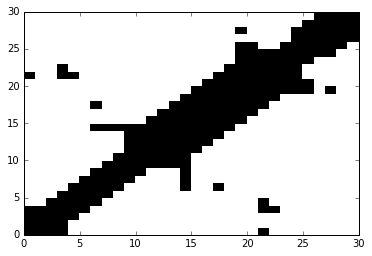

In [120]:
slice_len = min(seq_len, len(structure['sequence'])) - 2 * buffer

contacts = (structure['distance_map'] < distance_threshold).astype(int)[:seq_len, :seq_len]
plt.pcolor(contacts, cmap=matplotlib.cm.Greys)

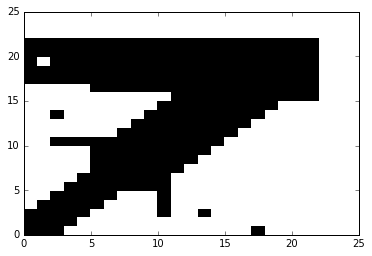

In [121]:
plt.pcolor(test_predicted.reshape(slice_len, slice_len), cmap=matplotlib.cm.Greys)

In [122]:
test_predicted.reshape(slice_len, slice_len)[:10][:10]

array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])